<a href="https://colab.research.google.com/github/KorwinBieniek/kaggle_projects/blob/main/notebooks/dogs_cats_classification/TransferLearningStanfordDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment 1: Follow the tutorial above and train a CNN model to distinguish between cats and dogs. Use a learning rate of 0.0001 instead of the one that is used in the tutorial
### Train a model (with the same architecture as the model in the tutorial) on the Stanford Dogs dataset: https://www.tensorflow.org/datasets/catalog/stanford_dogs (Links to an external site.). When trained, save this model to a file.

### Experiment 2: Load the saved model and replace only the output layer of the model (to align it to the new problem). When this is done, train and evaluate the model (for 50 epochs) on the cats and dogs dataset.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   197M      0  0:00:03  0:00:03 --:--:--  196M


In [4]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A y
 dogs_cats_model.h5	       PetImages        stanford_dogs_model.h5
 kagglecatsanddogs_3367a.zip  'readme[1].txt'
'MSR-LA - 3467.docx'	       sample_data


In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
image_size = (180, 180)
batch_size = 32
SMOKE_TEST = False

if SMOKE_TEST:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "PetImages",
        validation_split=0.92,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "PetImages",
        validation_split=0.02,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
else:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "PetImages",
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "PetImages",
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


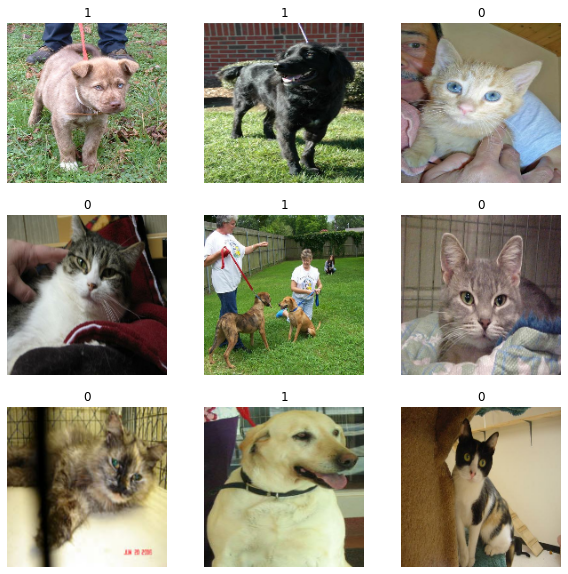

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

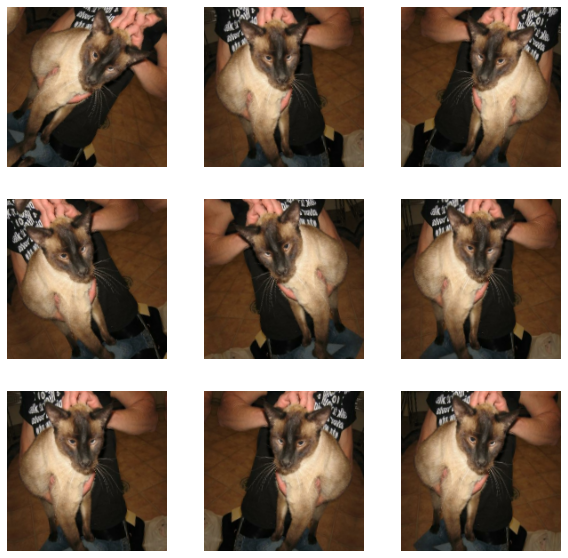

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Model Loading, enabling only the output layer to be trained.

In [12]:
model_loaded = keras.models.load_model('stanford_dogs_model.h5')

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model_exp2 = make_model(input_shape=(180, 180, 3), num_classes=2)

In [13]:
temp_weights = [layer.get_weights() for layer in model_loaded.layers]

In [14]:
for layer, weight in zip(model_exp2.layers, temp_weights):
  try:
    layer.set_weights(weight)
  except ValueError:
    print(layer)

In [15]:
for layer in model_exp2.layers[:-1]:
  layer.trainable = False

In [16]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_exp2.h5"),
]
model_exp2.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model_exp2.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - 49s 74ms/step - loss: 343.4739 - accuracy: 0.5067 - val_loss: 45.2777 - val_accuracy: 0.6004
Epoch 2/5
586/586 [==============================] - 45s 75ms/step - loss: 257.6552 - accuracy: 0.5257 - val_loss: 59.2540 - val_accuracy: 0.6168
Epoch 3/5
586/586 [==============================] - 43s 73ms/step - loss: 191.5784 - accuracy: 0.5470 - val_loss: 51.3627 - val_accuracy: 0.6211
Epoch 4/5
586/586 [==============================] - 41s 70ms/step - loss: 140.7107 - accuracy: 0.5564 - val_loss: 49.7874 - val_accuracy: 0.6091
Epoch 5/5
586/586 [==============================] - 41s 69ms/step - loss: 99.3890 - accuracy: 0.5623 - val_loss: 26.4172 - val_accuracy: 0.6501


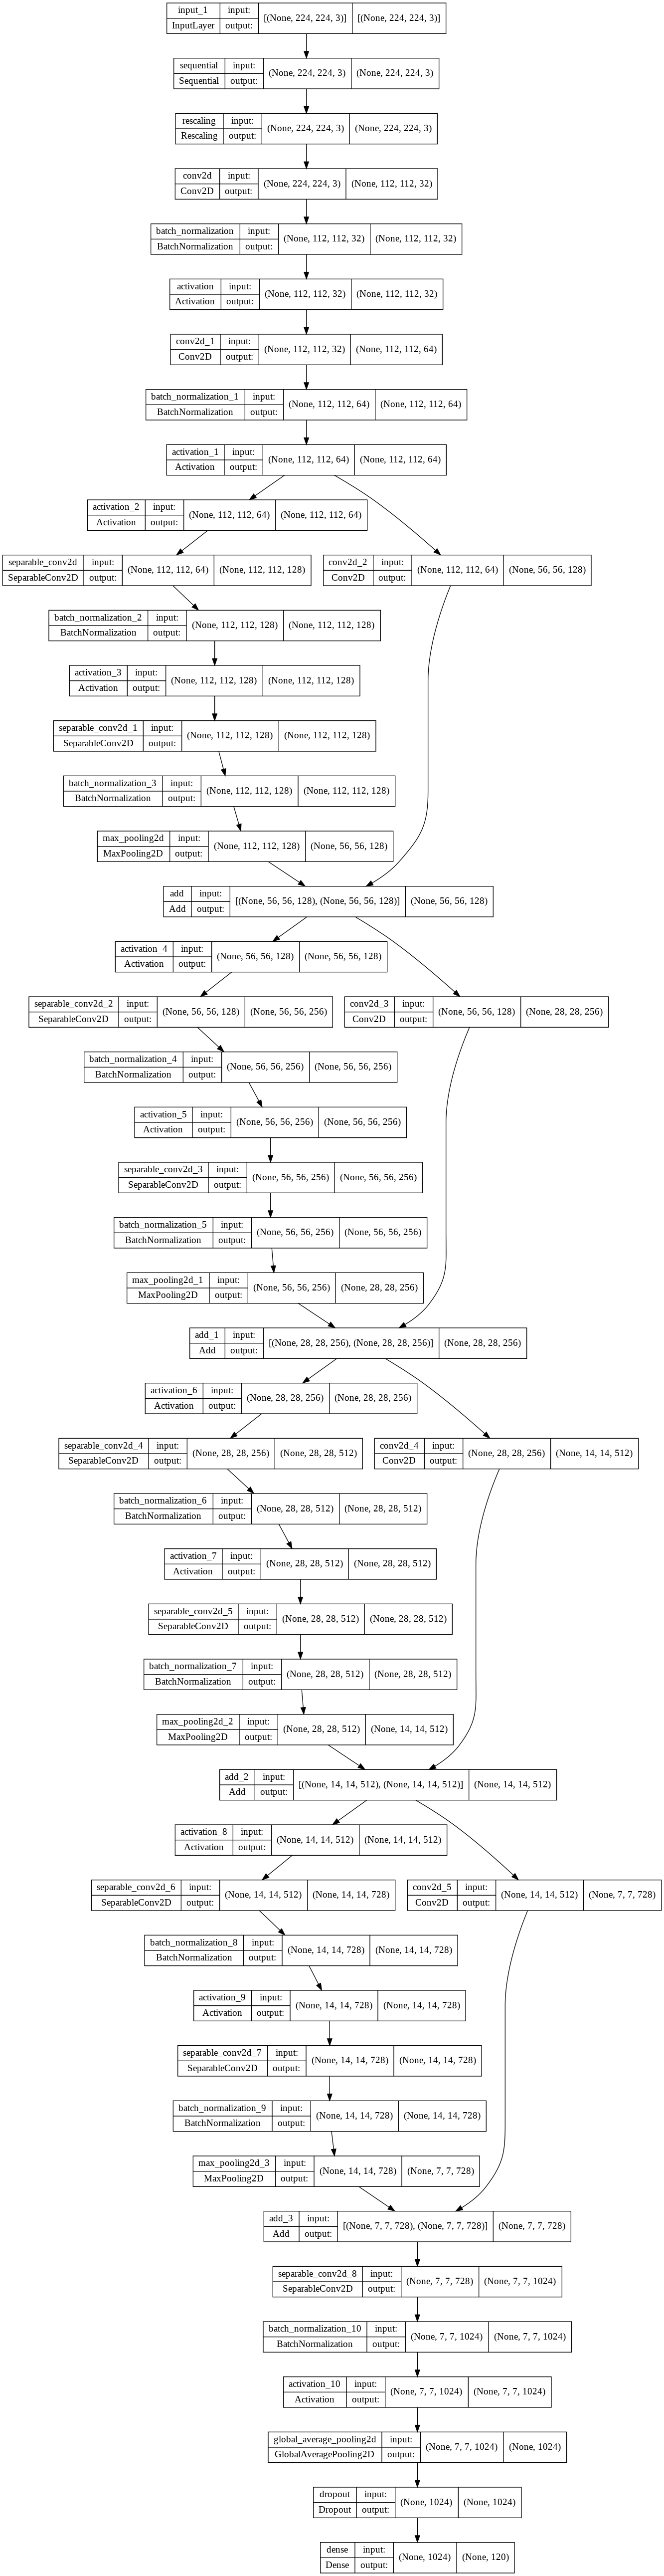

In [29]:
keras.utils.plot_model(model_loaded, show_shapes=True)

### Test the results

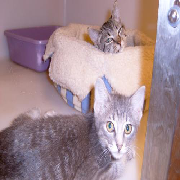

This image is 0.00 percent cat and 100.00 percent dog.


In [23]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6139.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
display(img)
predictions = model.predict(img_array)
score = predictions.item()
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

### Experiment 3: Load the saved model and replace the output layer of the model, as well as the first two convolutional layers (keep the weights of all other layers). Train and evaluate the model on the cats and dogs dataset when this is done.

In [14]:
model_exp3 = make_model(input_shape=(180, 180, 3), num_classes=2)

In [16]:
temp_weights = [layer.get_weights() for layer in model_loaded.layers]

In [17]:
for layer, weight in zip(model_exp3.layers, temp_weights):
  try:
    layer.set_weights(weight)
  except ValueError:
    print(layer)

In [18]:
layer_names = ['conv2d_12', 'conv2d_13', 'dense_2']

for layer in model_exp3.layers:
  if not layer.name in layer_names:
    layer.trainable = False

In [19]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_exp3.h5"),
]
model_exp3.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model_exp3.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - 44s 67ms/step - loss: 395.0631 - accuracy: 0.5032 - val_loss: 91.5142 - val_accuracy: 0.5103
Epoch 2/5
586/586 [==============================] - 41s 69ms/step - loss: 384.0851 - accuracy: 0.5125 - val_loss: 91.5142 - val_accuracy: 0.5103
Epoch 3/5
586/586 [==============================] - 41s 70ms/step - loss: 392.9004 - accuracy: 0.5003 - val_loss: 91.5142 - val_accuracy: 0.5103
Epoch 4/5
586/586 [==============================] - 41s 69ms/step - loss: 387.9466 - accuracy: 0.5048 - val_loss: 91.5142 - val_accuracy: 0.5103
Epoch 5/5
586/586 [==============================] - 41s 69ms/step - loss: 392.6088 - accuracy: 0.5027 - val_loss: 91.5142 - val_accuracy: 0.5103


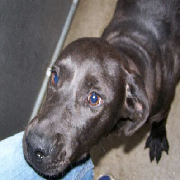

This image is 50.01 percent cat and 49.99 percent dog.


In [28]:
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/6149.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
display(img)
predictions = model.predict(img_array)
score = predictions.item()
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

### Experiment 4: Load the saved model and replace the output layer of the model, as well as the two last convolutional layers. Train and evaluate the model on the cats and dogs dataset when this is done.

In [52]:
model_exp4 = make_model(input_shape=(180, 180, 3), num_classes=2)

In [53]:
temp_weights = [layer.get_weights() for layer in model_loaded.layers]

In [54]:
for layer, weight in zip(model_exp4.layers, temp_weights):
  try:
    layer.set_weights(weight)
  except ValueError:
    print(layer)

In [55]:
layer_names = ['separable_conv2d_25', 'separable_conv2d_26', 'dense_2']

for layer in model_exp4.layers:
  if not layer.name in layer_names:
    layer.trainable = False

In [56]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_exp4.h5"),
]
model_exp4.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model_exp4.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - 45s 73ms/step - loss: 432.5263 - accuracy: 0.4894 - val_loss: 142.4916 - val_accuracy: 0.4930
Epoch 2/5
586/586 [==============================] - 42s 72ms/step - loss: 423.4147 - accuracy: 0.4965 - val_loss: 142.4917 - val_accuracy: 0.4930
Epoch 3/5
586/586 [==============================] - 42s 71ms/step - loss: 431.2523 - accuracy: 0.4906 - val_loss: 142.4917 - val_accuracy: 0.4930
Epoch 4/5
586/586 [==============================] - 42s 71ms/step - loss: 428.9854 - accuracy: 0.4958 - val_loss: 142.4917 - val_accuracy: 0.4930
Epoch 5/5
586/586 [==============================] - 41s 70ms/step - loss: 426.5904 - accuracy: 0.4941 - val_loss: 142.4917 - val_accuracy: 0.4930


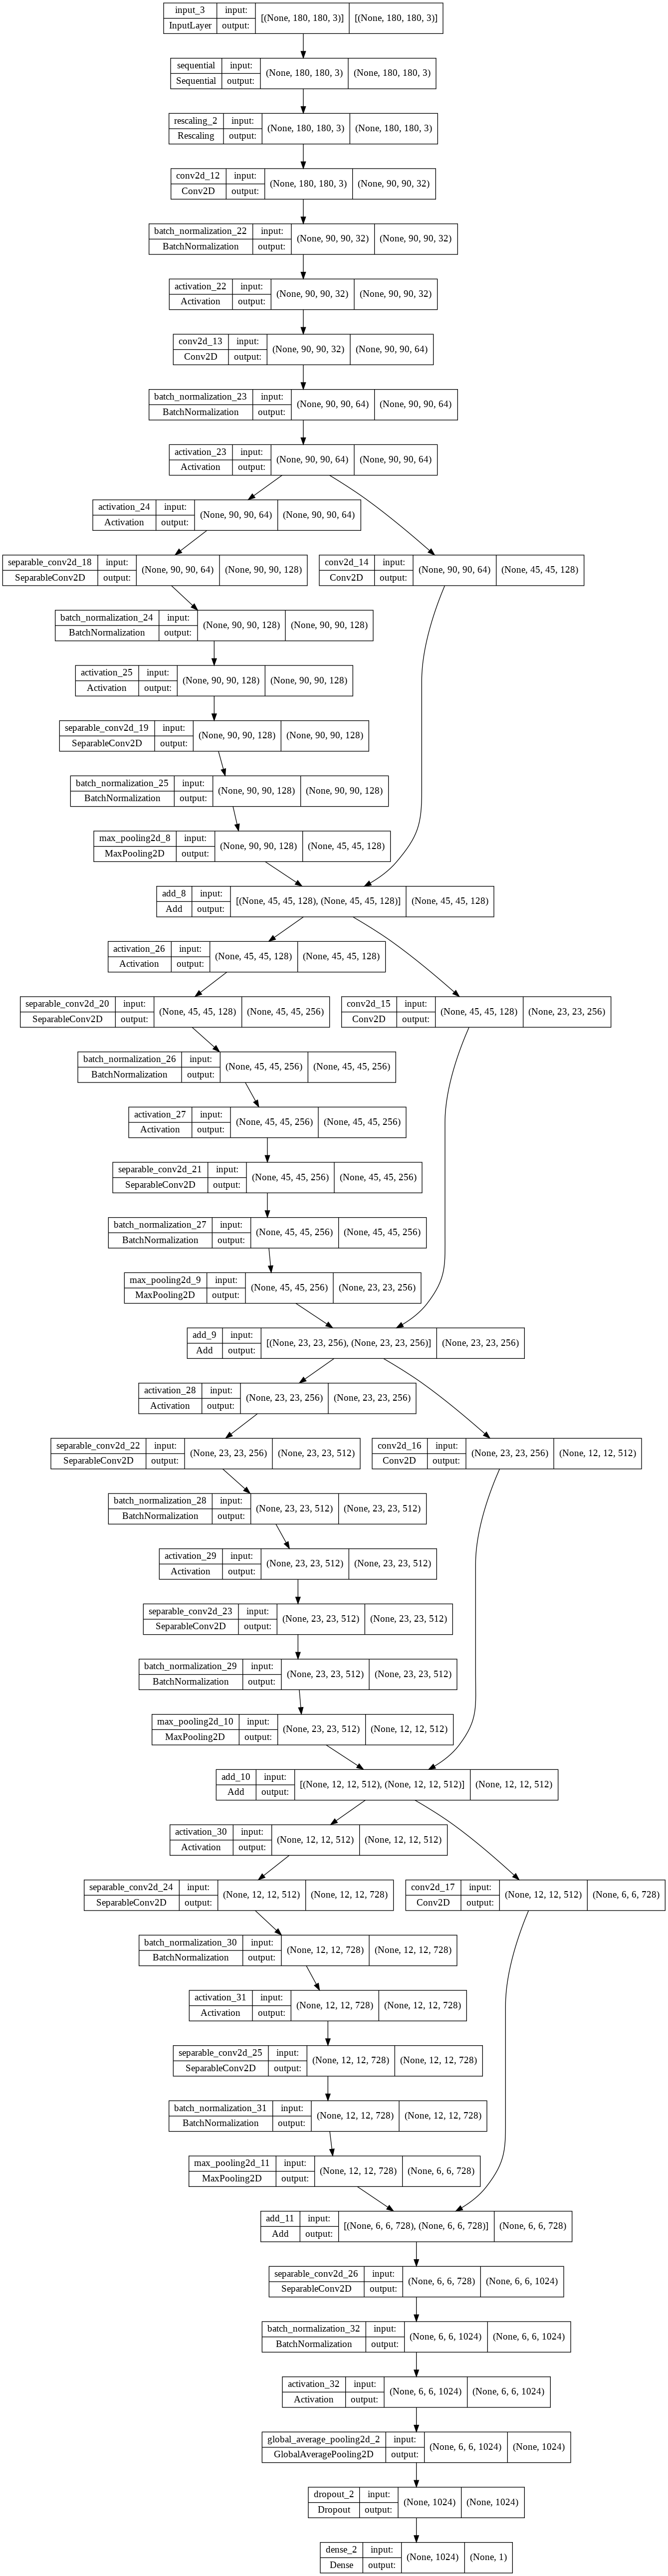

In [36]:
keras.utils.plot_model(model_exp4, show_shapes=True)

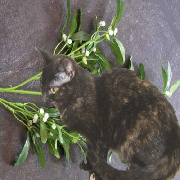

This image is 27.77 percent cat and 72.23 percent dog.


In [45]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6559.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
display(img)
predictions = model_exp4.predict(img_array)
score = predictions.item()
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)